## df_deaths dataset

In [50]:
# Necessary libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Let's start with deaths from asthma from 2014-2019
df_deaths = pd.read_csv('asthma-deaths-by-county-2014_2019.csv', encoding='latin1')
df_deaths.head()

,COUNTY,YEARS,STRATA,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,COMMENT
0,California,2014-2016,Total population,All ages,"1,181",9.6,NaN
1,Alameda,2014-2016,Total population,All ages,58,11.2,NaN
2,Alpine,2014-2016,Total population,All ages,0,0.0,NaN
3,Amador,2014-2016,Total population,All ages,0,0.0,NaN
4,Butte,2014-2016,Total population,All ages,7,NaN,Rate not available due to statistical instability


In [3]:
# Let's remove Strata and comment section from this analysis
df_deaths.drop(columns = ['STRATA','COMMENT'],inplace=True)
df_deaths

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE
0,California,2014-2016,All ages,"1,181",9.6
1,Alameda,2014-2016,All ages,58,11.2
2,Alpine,2014-2016,All ages,0,0.0
3,Amador,2014-2016,All ages,0,0.0
4,Butte,2014-2016,All ages,7,NaN
...,...,...,...,...,...
349,Tulare,2017-2019,18+ years,16,15.5
350,Tuolumne,2017-2019,18+ years,NaN,NaN
351,Ventura,2017-2019,18+ years,17,7.7
352,Yolo,2017-2019,18+ years,NaN,NaN


In [4]:
# Let's start cleaning. 
df_deaths.dtypes #number of deaths should be integer

COUNTY                          object
YEARS                           object
AGE GROUP                       object
NUMBER OF DEATHS                object
AGE-ADJUSTED MORTALITY RATE    float64
dtype: object

In [5]:
df_deaths['NUMBER OF DEATHS'] = df_deaths['NUMBER OF DEATHS'].str.replace(',','').fillna(0).astype(int)  #Replacing the commas and filling NA's with 0

In [6]:
df_deaths

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE
0,California,2014-2016,All ages,1181,9.6
1,Alameda,2014-2016,All ages,58,11.2
2,Alpine,2014-2016,All ages,0,0.0
3,Amador,2014-2016,All ages,0,0.0
4,Butte,2014-2016,All ages,7,NaN
...,...,...,...,...,...
349,Tulare,2017-2019,18+ years,16,15.5
350,Tuolumne,2017-2019,18+ years,0,NaN
351,Ventura,2017-2019,18+ years,17,7.7
352,Yolo,2017-2019,18+ years,0,NaN


In [7]:
# Since we replaced the number of deaths having NA values with 0. Let's first deal with it
# Let's see if we can replace it with mean or median
mn = df_deaths.groupby('AGE GROUP')['NUMBER OF DEATHS'].mean()
md = df_deaths.groupby('AGE GROUP')['NUMBER OF DEATHS'].median()

In [8]:
print("Mean is :", mn)
print("\n\nMedian is :",md)  #Therefore mean seems to be a good method.

Mean is : AGE GROUP
0-17 years     1.000000
18+ years     37.415254
All ages      38.949153
Name: NUMBER OF DEATHS, dtype: float64


Median is : AGE GROUP
0-17 years    0.0
18+ years     3.0
All ages      6.0
Name: NUMBER OF DEATHS, dtype: float64


We are moving with mean in this case as we cannot for data retrival team to do the work properly. But in this case, we should always contact the team to provide or change the method of data retrival, as we can clearly see, that data collected from 0-17 age group has mostly 0 values which is not accurate but in this case we replace by mean so that data can be ready for analysis. But the analysis can be better if that data retrival or provided would be better

In [9]:
def fill_zeros(row):  #making a function to fill with age group mean, if found 0 in a particular age group mean
    if row['NUMBER OF DEATHS'] == 0:
        return mn[row['AGE GROUP']]
    else:
        return row['NUMBER OF DEATHS']

# Applying the function
df_deaths['NUMBER OF DEATHS'] = df_deaths.apply(fill_zeros, axis=1)

df_deaths['NUMBER OF DEATHS'] = df_deaths['NUMBER OF DEATHS'].round().astype(int)

In [10]:
df_deaths

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE
0,California,2014-2016,All ages,1181,9.6
1,Alameda,2014-2016,All ages,58,11.2
2,Alpine,2014-2016,All ages,39,0.0
3,Amador,2014-2016,All ages,39,0.0
4,Butte,2014-2016,All ages,7,NaN
...,...,...,...,...,...
349,Tulare,2017-2019,18+ years,16,15.5
350,Tuolumne,2017-2019,18+ years,37,NaN
351,Ventura,2017-2019,18+ years,17,7.7
352,Yolo,2017-2019,18+ years,37,NaN


In [11]:
# Now lets deal with age adjusted mortality rate in the same manner

mn1 = df_deaths.groupby('AGE GROUP')['AGE-ADJUSTED MORTALITY RATE'].mean()
md1 = df_deaths.groupby('AGE GROUP')['AGE-ADJUSTED MORTALITY RATE'].median()

In [12]:
print("Mean is :", mn1)
print("\n\nMedian is :",md1)  #Therefore mean seems to be a good method again.

#Again if we could have, we would have asked the data retrieval to be done properly

Mean is : AGE GROUP
0-17 years     0.073864
18+ years     10.732759
All ages       8.218966
Name: AGE-ADJUSTED MORTALITY RATE, dtype: float64


Median is : AGE GROUP
0-17 years     0.00
18+ years     11.90
All ages       9.05
Name: AGE-ADJUSTED MORTALITY RATE, dtype: float64


In [13]:
def fill_zeros1(row):  #making similar function
    if row['AGE-ADJUSTED MORTALITY RATE'] == 0 or math.isnan(row['AGE-ADJUSTED MORTALITY RATE']):
        return mn1[row['AGE GROUP']]
    else:
        return row['AGE-ADJUSTED MORTALITY RATE']

# Applying the function
df_deaths['AGE-ADJUSTED MORTALITY RATE'] = df_deaths.apply(fill_zeros1, axis=1)

df_deaths['AGE-ADJUSTED MORTALITY RATE'] = round(df_deaths['AGE-ADJUSTED MORTALITY RATE'],2) #rounding up to 2 decimals

In [14]:
df_deaths.head()

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE
0,California,2014-2016,All ages,1181,9.60
1,Alameda,2014-2016,All ages,58,11.20
2,Alpine,2014-2016,All ages,39,8.22
3,Amador,2014-2016,All ages,39,8.22
4,Butte,2014-2016,All ages,7,8.22


In [15]:
df_deaths.describe()

,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE
count,354.000000,354.000000
mean,38.446328,7.107486
std,124.128936,5.693896
min,1.000000,0.070000
25%,1.000000,0.070000
50%,22.500000,8.220000
75%,39.000000,10.730000
max,1181.000000,27.600000


In [16]:
df_deaths['YEARS'].unique()

array(['2014-2016', '2017-2019'], dtype=object)

In [17]:
df_deaths['AGE GROUP'].unique()

array(['All ages', '0-17 years', '18+ years'], dtype=object)

In [18]:
# Converting the years column and age group column into numerical from categorical

age_group_mapping = {'All ages': 0, '0-17 years': 1, '18+ years': 2}

# Apply mapping to the 'AGE GROUP' column
df_deaths['NUMERIC AGE GROUP'] = df_deaths['AGE GROUP'].map(age_group_mapping)

years_mapping = {'2014-2016': 0, '2017-2019': 1}

# Apply mapping to the 'YEARS' column
df_deaths['NUMERIC YEARS'] = df_deaths['YEARS'].map(years_mapping)

df_deaths.head()

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,NUMERIC AGE GROUP,NUMERIC YEARS
0,California,2014-2016,All ages,1181,9.60,0,0
1,Alameda,2014-2016,All ages,58,11.20,0,0
2,Alpine,2014-2016,All ages,39,8.22,0,0
3,Amador,2014-2016,All ages,39,8.22,0,0
4,Butte,2014-2016,All ages,7,8.22,0,0


In [19]:
df_deaths[df_deaths['COUNTY'] != 'California']

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,NUMERIC AGE GROUP,NUMERIC YEARS
1,Alameda,2014-2016,All ages,58,11.20,0,0
2,Alpine,2014-2016,All ages,39,8.22,0,0
3,Amador,2014-2016,All ages,39,8.22,0,0
4,Butte,2014-2016,All ages,7,8.22,0,0
5,Calaveras,2014-2016,All ages,39,8.22,0,0
...,...,...,...,...,...,...,...
349,Tulare,2017-2019,18+ years,16,15.50,2,1
350,Tuolumne,2017-2019,18+ years,37,10.73,2,1
351,Ventura,2017-2019,18+ years,17,7.70,2,1
352,Yolo,2017-2019,18+ years,37,10.73,2,1


In [20]:
# First row for each age group is summation of all deaths and overall age-adjusted mortality rate. We need to omit that
# as it would create baisness.

df_deaths1 = df_deaths[df_deaths['COUNTY'] != 'California']
df_deaths1.head()

,COUNTY,YEARS,AGE GROUP,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,NUMERIC AGE GROUP,NUMERIC YEARS
1,Alameda,2014-2016,All ages,58,11.20,0,0
2,Alpine,2014-2016,All ages,39,8.22,0,0
3,Amador,2014-2016,All ages,39,8.22,0,0
4,Butte,2014-2016,All ages,7,8.22,0,0
5,Calaveras,2014-2016,All ages,39,8.22,0,0


## K-Means Clustering on this dataset

In [43]:
X = df_deaths1[['NUMBER OF DEATHS', 'AGE-ADJUSTED MORTALITY RATE', 'NUMERIC AGE GROUP', 'NUMERIC YEARS']]
#X = df_deaths1[['NUMBER OF DEATHS', 'AGE-ADJUSTED MORTALITY RATE']]

# Identify outliers using z-score
z_scores = np.abs(stats.zscore(X))
threshold = 3
outlier_indices = np.where(z_scores > threshold)

# Removing the outliers
X = X[(z_scores < threshold).all(axis=1)]
df_deaths1 = df_deaths1.drop(outlier_indices[0])

scaler = StandardScaler()   #using standard scaler to normalize it
X_scaled1 = scaler.fit_transform(X)
X_scaled1

array([[ 1.7357755 ,  0.79094495, -1.22031999, -0.99707174],
       [ 0.80419088,  0.24379056, -1.22031999, -0.99707174],
       [ 0.80419088,  0.24379056, -1.22031999, -0.99707174],
       ...,
       [-0.27448604,  0.14831396,  1.24198247,  1.00293686],
       [ 0.70612935,  0.70464879,  1.24198247,  1.00293686],
       [ 0.70612935,  0.70464879,  1.24198247,  1.00293686]])

In [44]:
#X = df_deaths[['NUMBER OF DEATHS', 'AGE-ADJUSTED MORTALITY RATE', 'NUMERIC AGE GROUP', 'NUMERIC YEARS']]
X = df_deaths1[['NUMBER OF DEATHS', 'AGE-ADJUSTED MORTALITY RATE']]

scaler = StandardScaler()   #using standard scaler to normalize it
X_scaled2 = scaler.fit_transform(X)
X_scaled2

array([[ 0.94319458,  0.72543591],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [-0.5368286 ,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.42083346,  0.62096481],
       [ 0.39181339,  0.20656276],
       [-0.5368286 ,  0.20656276],
       [ 0.39181339,  1.30002698],
       [ 0.39181339,  0.20656276],
       [-0.44976841,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [-0.10152767,  0.39461075],
       [-0.56584866,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 8.11114997,  0.48167   ],
       [-0.56584866,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [-0.27564804,  2.53626839],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [-0.18858785,  1.24779143],
       [ 0.39181339,  0.20656276],
       [ 0.39181339,  0.20656276],
       [ 0.85613439,

#### KMeans Clustering with Categorical Variables(after converted to numerical ones)

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid i

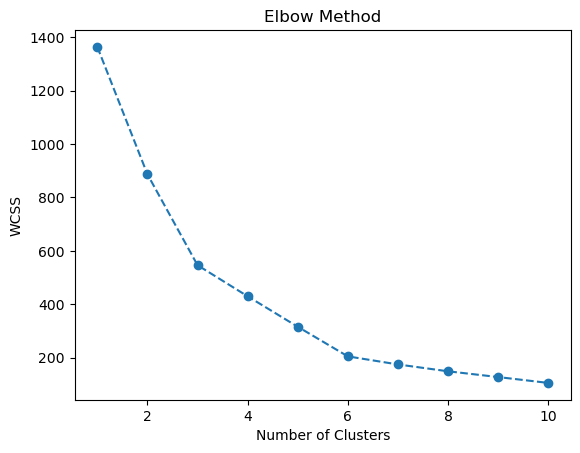

In [45]:
wcss = []

# experimenting for 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled1)
    wcss.append(kmeans.inertia_)

# plotting the curve that is basically elbow method
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Clusters coming out to be 6 or 7 from elbow method

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid i

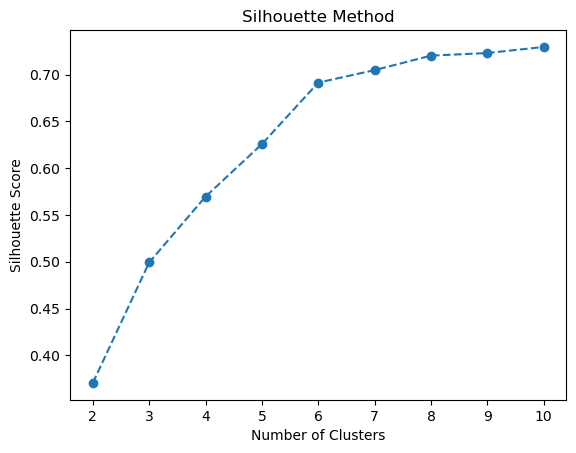

In [48]:
s_scores = []

# Plotting with different values of cluster
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled1)
    labels = kmeans.labels_
    s_avg = silhouette_score(X_scaled1, labels)
    s_scores.append(s_avg)

# plotting the silhouette graph
plt.plot(range(2, 11), s_scores, marker='o', linestyle='--')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Here the silhoutte method is suggesting around 8.

Lets try with 6,7,8 to check our results

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


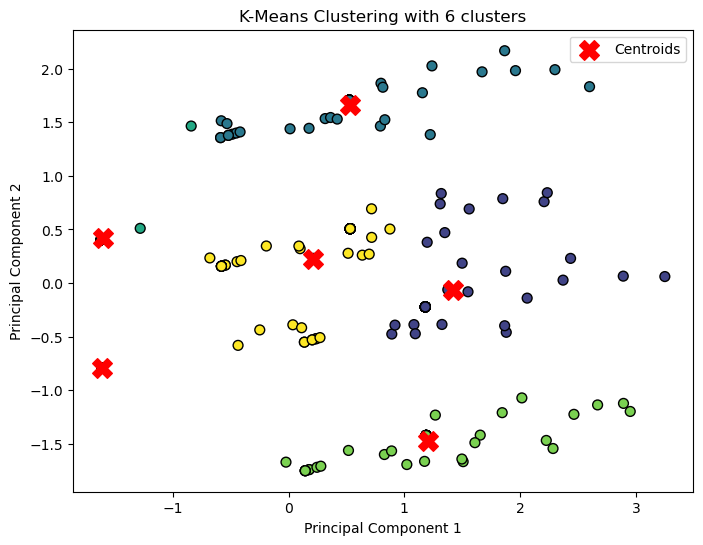

In [51]:
# performing kmeans clustering with 6 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled1)

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 6 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [52]:
X_scaled1_df = pd.DataFrame(X_scaled1, columns=['NUMBER OF DEATHS','AGE-ADJUSTED MORTALITY RATE','NUMERIC AGE GROUP','NUMERIC YEARS'])
X_scaled1_df['CLUSTER'] = kmeans.labels_
X_scaled1_df.head()

,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,NUMERIC AGE GROUP,NUMERIC YEARS,CLUSTER
0,1.735775,0.790945,-1.22032,-0.997072,1
1,0.804191,0.243791,-1.22032,-0.997072,5
2,0.804191,0.243791,-1.22032,-0.997072,5
3,-0.764794,0.243791,-1.22032,-0.997072,5
4,0.804191,0.243791,-1.22032,-0.997072,5


In [53]:
X_scaled1_df['PCA1'] = X_pca[:, 0]
X_scaled1_df['PCA2'] = X_pca[:, 1]
X_scaled1_df.head()

,NUMBER OF DEATHS,AGE-ADJUSTED MORTALITY RATE,NUMERIC AGE GROUP,NUMERIC YEARS,CLUSTER,PCA1,PCA2
0,1.735775,0.790945,-1.22032,-0.997072,1,1.559661,0.691124
1,0.804191,0.243791,-1.22032,-0.997072,5,0.532070,0.506824
2,0.804191,0.243791,-1.22032,-0.997072,5,0.532070,0.506824
3,-0.764794,0.243791,-1.22032,-0.997072,5,-0.545450,0.167260
4,0.804191,0.243791,-1.22032,-0.997072,5,0.532070,0.506824


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


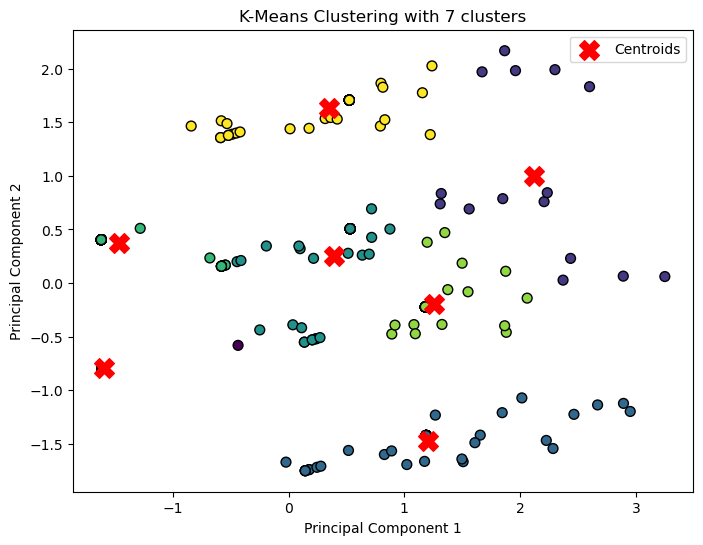

In [54]:
# performing kmeans clustering with 7 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled1)

kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 7 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


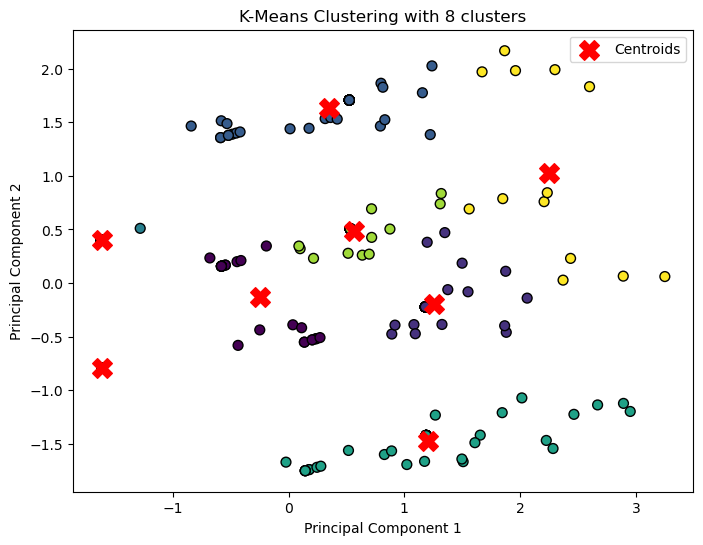

In [55]:
# performing kmeans clustering with 8 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled1)

kmeans = KMeans(n_clusters=8, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 8 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#### KMeans Clustering without Categorical Variables(after converted to numerical ones)

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid i

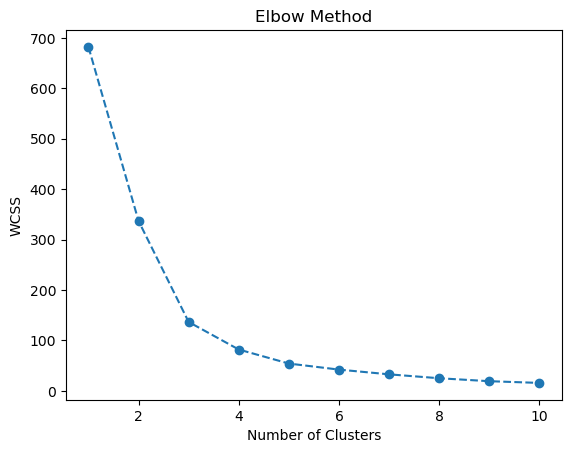

In [56]:
wcss = []

# experimenting for 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled2)
    wcss.append(kmeans.inertia_)

# plotting the curve that is basically elbow method
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Number of clusters seems to be near 4 or 5

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid i

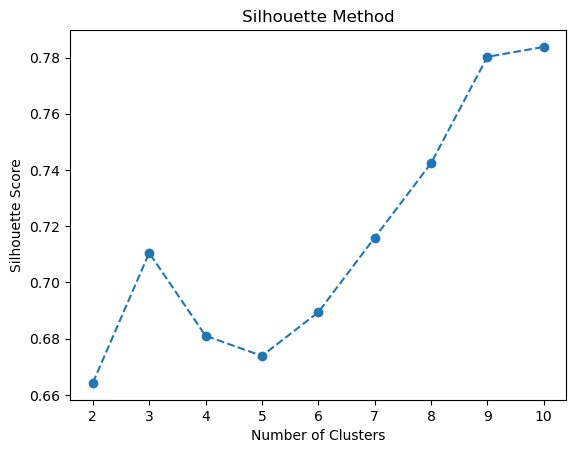

In [57]:
s_scores = []

# Plotting with different values of cluster
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled2)
    labels = kmeans.labels_
    s_avg = silhouette_score(X_scaled2, labels)
    s_scores.append(s_avg)

# plotting the silhouette graph
plt.plot(range(2, 11), s_scores, marker='o', linestyle='--')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Silhouette score doesn't seem to be a good method here and so going with elbow method and trying for clusters 4,5,6

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


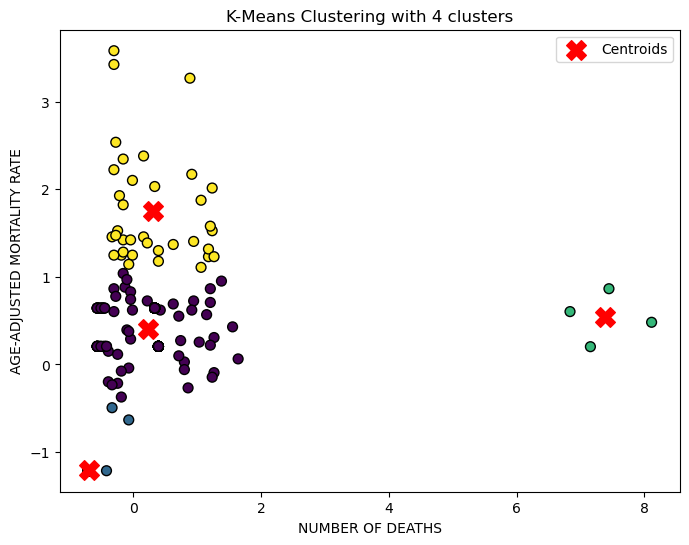

In [58]:
# performing kmeans clustering with 4 clusters

# Here PCA is not required as there are only 2 numeric variables

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(X_scaled2)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF DEATHS','AGE-ADJUSTED MORTALITY RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled2[:,0], X_scaled2[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 4 clusters')
plt.xlabel('NUMBER OF DEATHS')
plt.ylabel('AGE-ADJUSTED MORTALITY RATE')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


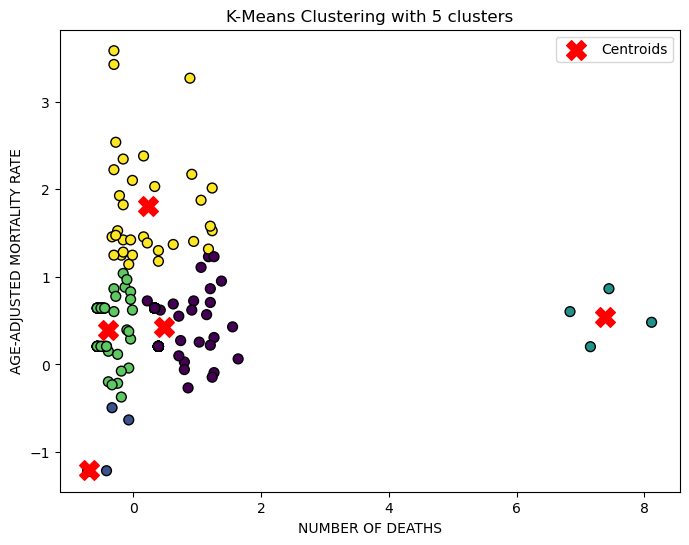

In [59]:
# performing kmeans clustering with 5 clusters

# Here PCA is not required as there are only 2 numeric variables

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_scaled2)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF DEATHS','AGE-ADJUSTED MORTALITY RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled2[:,0], X_scaled2[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 5 clusters')
plt.xlabel('NUMBER OF DEATHS')
plt.ylabel('AGE-ADJUSTED MORTALITY RATE')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


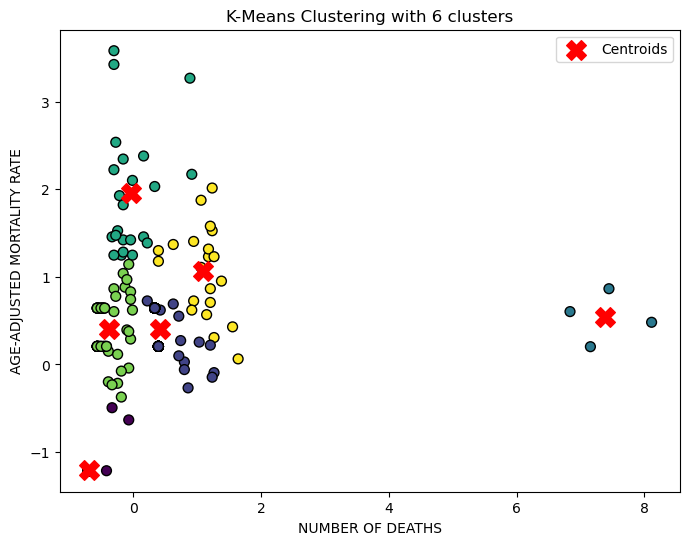

In [60]:
# performing kmeans clustering with 6 clusters

# Here PCA is not required as there are only 2 numeric variables

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_scaled2)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF DEATHS','AGE-ADJUSTED MORTALITY RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled2[:,0], X_scaled2[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 6 clusters')
plt.xlabel('NUMBER OF DEATHS')
plt.ylabel('AGE-ADJUSTED MORTALITY RATE')
plt.legend()
plt.show()

## df_ed dataset

In [21]:
df_ed = pd.read_csv('asthma-emergency-department-visit-rates-by-county-2015_2020.csv', encoding='latin1')
df_ed.head()

,COUNTY,YEAR,STRATA,STRATA NAME,AGE GROUP,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,COMMENT
0,California,2015,Total population,All ages,All ages,"191,904",50.4,NaN
1,Alameda,2015,Total population,All ages,All ages,"9,939",64.3,NaN
2,Alpine,2015,Total population,All ages,All ages,0,0.0,NaN
3,Amador,2015,Total population,All ages,All ages,196,58.4,NaN
4,Butte,2015,Total population,All ages,All ages,"1,044",50.2,NaN


In [22]:
# We dont want STRATA, STRATA NAME and COMMENT for analysis
df_ed.drop(columns = ['STRATA','STRATA NAME','COMMENT'],inplace=True)
df_ed

,COUNTY,YEAR,AGE GROUP,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE
0,California,2015,All ages,"191,904",50.4
1,Alameda,2015,All ages,"9,939",64.3
2,Alpine,2015,All ages,0,0.0
3,Amador,2015,All ages,196,58.4
4,Butte,2015,All ages,"1,044",50.2
...,...,...,...,...,...
4479,Tulare,2020,All ages,NaN,NaN
4480,Tuolumne,2020,All ages,0,0.0
4481,Ventura,2020,All ages,14,8.7
4482,Yolo,2020,All ages,11,NaN


In [23]:
df_ed.dtypes #We want Number of ED visits as integers

COUNTY                         object
YEAR                            int64
AGE GROUP                      object
NUMBER OF ED VISITS            object
AGE-ADJUSTED ED VISIT RATE    float64
dtype: object

In [24]:
df_ed.isna().sum() #We want to get rid of these missing values. Since its around 15% of the data and we want to avoid
# what happenend last time, this time we will drop it

COUNTY                          0
YEAR                            0
AGE GROUP                       0
NUMBER OF ED VISITS           681
AGE-ADJUSTED ED VISIT RATE    716
dtype: int64

In [25]:
df_ed.dropna(inplace = True)

In [26]:
df_ed.isna().sum() #The null values are removed. Now lets change the data types

COUNTY                        0
YEAR                          0
AGE GROUP                     0
NUMBER OF ED VISITS           0
AGE-ADJUSTED ED VISIT RATE    0
dtype: int64

In [27]:
df_ed['NUMBER OF ED VISITS'] = df_ed['NUMBER OF ED VISITS'].str.replace(',','').astype(int)

In [28]:
df_ed.dtypes

COUNTY                         object
YEAR                            int64
AGE GROUP                      object
NUMBER OF ED VISITS             int32
AGE-ADJUSTED ED VISIT RATE    float64
dtype: object

In [29]:
df_ed['AGE GROUP'].unique()

array(['All ages', '0\x9617 years', '18+ years', '0\x964 years',
       '5\x9617 years', '18\x9664 years', '65+ years'], dtype=object)

In [30]:
df_ed['AGE GROUP'] = df_ed['AGE GROUP'].str.replace('\x96','-')

In [31]:
df_ed['AGE GROUP'].unique()

array(['All ages', '0-17 years', '18+ years', '0-4 years', '5-17 years',
       '18-64 years', '65+ years'], dtype=object)

In [32]:
df_ed = df_ed[df_ed['NUMBER OF ED VISITS'] != 0]

In [33]:
df_ed.head()

,COUNTY,YEAR,AGE GROUP,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE
0,California,2015,All ages,191904,50.4
1,Alameda,2015,All ages,9939,64.3
3,Amador,2015,All ages,196,58.4
4,Butte,2015,All ages,1044,50.2
5,Calaveras,2015,All ages,185,48.0


In [34]:
df_ed.describe()

,YEAR,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE
count,3489.000000,3489.000000,3489.000000
mean,2017.505589,2194.580396,55.513414
std,1.704532,10483.701598,74.511910
min,2015.000000,12.000000,5.000000
25%,2016.000000,62.000000,28.100000
50%,2018.000000,259.000000,42.900000
75%,2019.000000,993.000000,64.500000
max,2020.000000,191904.000000,3531.000000


In [35]:
df_ed['YEAR'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [36]:
df_ed['AGE GROUP'].unique()

array(['All ages', '0-17 years', '18+ years', '0-4 years', '5-17 years',
       '18-64 years', '65+ years'], dtype=object)

In [37]:
year_mapping = {2015: 0, 2016: 1, 2017: 2, 2018: 3, 2019: 4, 2020: 5}

# Apply mapping to the 'YEARS' column
df_ed['NUMERIC YEAR'] = df_ed['YEAR'].map(year_mapping)

age_group_mapping = {'All ages': 0, '0-17 years': 1, '18+ years': 2, '0-4 years': 3, '5-17 years': 4,
       '18-64 years': 5, '65+ years': 6}

# Apply mapping to the 'AGE GROUP' column
df_ed['NUMERIC AGE GROUP'] = df_ed['AGE GROUP'].map(age_group_mapping)

df_ed.head()

C:\Users\kalpm\AppData\Local\Temp\ipykernel_115724\694938273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ed['NUMERIC YEAR'] = df_ed['YEAR'].map(year_mapping)
C:\Users\kalpm\AppData\Local\Temp\ipykernel_115724\694938273.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ed['NUMERIC AGE GROUP'] = df_ed['AGE GROUP'].map(age_group_mapping)


,COUNTY,YEAR,AGE GROUP,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC YEAR,NUMERIC AGE GROUP
0,California,2015,All ages,191904,50.4,0,0
1,Alameda,2015,All ages,9939,64.3,0,0
3,Amador,2015,All ages,196,58.4,0,0
4,Butte,2015,All ages,1044,50.2,0,0
5,Calaveras,2015,All ages,185,48.0,0,0


In [38]:
df_ed1 = df_ed[df_ed['COUNTY'] != 'California']
df_ed1.head()

,COUNTY,YEAR,AGE GROUP,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC YEAR,NUMERIC AGE GROUP
1,Alameda,2015,All ages,9939,64.3,0,0
3,Amador,2015,All ages,196,58.4,0,0
4,Butte,2015,All ages,1044,50.2,0,0
5,Calaveras,2015,All ages,185,48.0,0,0
6,Colusa,2015,All ages,97,41.4,0,0


In [39]:
df_ed1.describe()

,YEAR,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC YEAR,NUMERIC AGE GROUP
count,3413.000000,3413.000000,3413.000000,3413.000000,3413.000000
mean,2017.503369,1117.126282,55.603076,2.503369,1.886610
std,1.704006,3170.231469,75.130637,1.704006,2.132284
min,2015.000000,12.000000,5.000000,0.000000,0.000000
25%,2016.000000,61.000000,28.100000,1.000000,0.000000
50%,2018.000000,233.000000,43.000000,3.000000,1.000000
75%,2019.000000,907.000000,64.500000,4.000000,4.000000
max,2020.000000,52227.000000,3531.000000,5.000000,6.000000


### K-Means Clustering implementation on this dataset

In [61]:
X = df_ed1[['NUMBER OF ED VISITS', 'AGE-ADJUSTED ED VISIT RATE', 'NUMERIC AGE GROUP', 'NUMERIC YEAR']]

# Identify outliers using z-score
z_scores1 = np.abs(stats.zscore(X))
threshold1 = 3
outlier_indices1 = np.where(z_scores1 > threshold1)[0]  # Get the indices directly

# Removing the outliers from X
X = X[(z_scores1 < threshold1).all(axis=1)]

# Removing corresponding rows from df_ed1
df_ed1 = df_ed1.drop(df_ed1.index[outlier_indices1])

scaler = StandardScaler()   # using standard scaler to normalize it
X_scaled3 = scaler.fit_transform(X)
X_scaled3

array([[ 6.15411818,  0.30503323, -0.89080194, -1.47227285],
       [-0.43339899,  0.15140909, -0.89080194, -1.47227285],
       [ 0.13995773, -0.06210243, -0.89080194, -1.47227285],
       ...,
       [-0.54496015, -1.23901959, -0.89080194,  1.45949179],
       [-0.53481822, -0.90833711, -0.89080194,  1.45949179],
       [-0.55645433, -1.14267903, -0.89080194,  1.45949179]])

In [76]:
X = df_ed1[['NUMBER OF ED VISITS', 'AGE-ADJUSTED ED VISIT RATE']]

scaler = StandardScaler()   #using standard scaler to normalize it
X_scaled4 = scaler.fit_transform(X)
X_scaled4

array([[ 6.15411818,  0.30503323],
       [-0.43339899,  0.15140909],
       [ 0.13995773, -0.06210243],
       ...,
       [-0.54496015, -1.23901959],
       [-0.53481822, -0.90833711],
       [-0.55645433, -1.14267903]])

In [62]:
df_ed_normalized = pd.DataFrame(X_scaled3,columns=['NUMBER OF ED VISITS', 'AGE-ADJUSTED ED VISIT RATE', 'NUMERIC AGE GROUP', 'NUMERIC YEAR'])
df_ed_normalized.head()

,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC AGE GROUP,NUMERIC YEAR
0,6.154118,0.305033,-0.890802,-1.472273
1,-0.433399,0.151409,-0.890802,-1.472273
2,0.139958,-0.062102,-0.890802,-1.472273
3,-0.440836,-0.119386,-0.890802,-1.472273
4,-0.500336,-0.291237,-0.890802,-1.472273


#### K Means with categorical variables

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

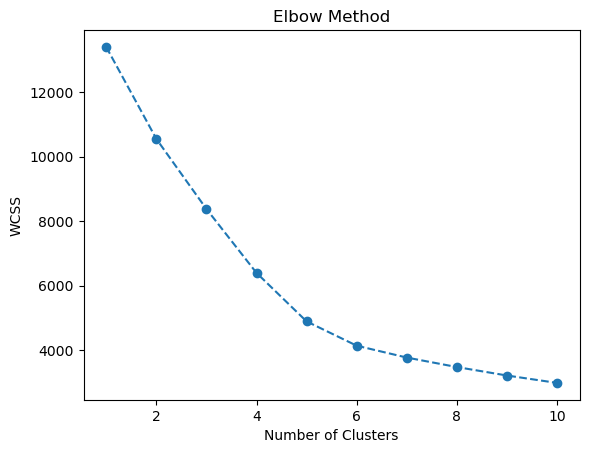

In [63]:
wcss = []

# experimenting for 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled3)
    wcss.append(kmeans.inertia_)

# plotting the curve that is basically elbow method
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

From elbow method the number of clusters seems around 6

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

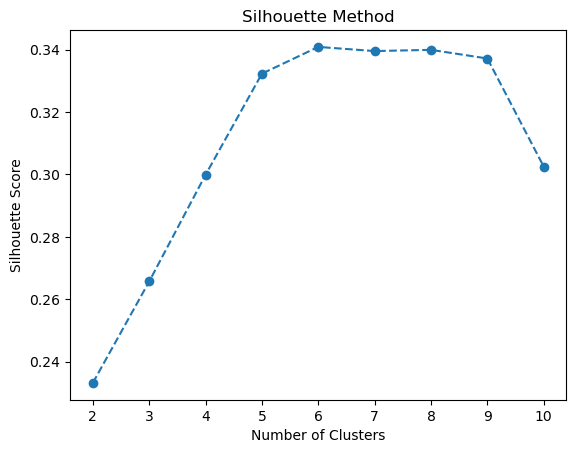

In [64]:
s_scores = []

# Plotting with different values of cluster
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled3)
    labels = kmeans.labels_
    s_avg = silhouette_score(X_scaled3, labels)
    s_scores.append(s_avg)

# plotting the silhouette graph
plt.plot(range(2, 11), s_scores, marker='o', linestyle='--')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

From the silhouette method, the number of clusters seems to be 6. Therefore lets try 5,6 and 7

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


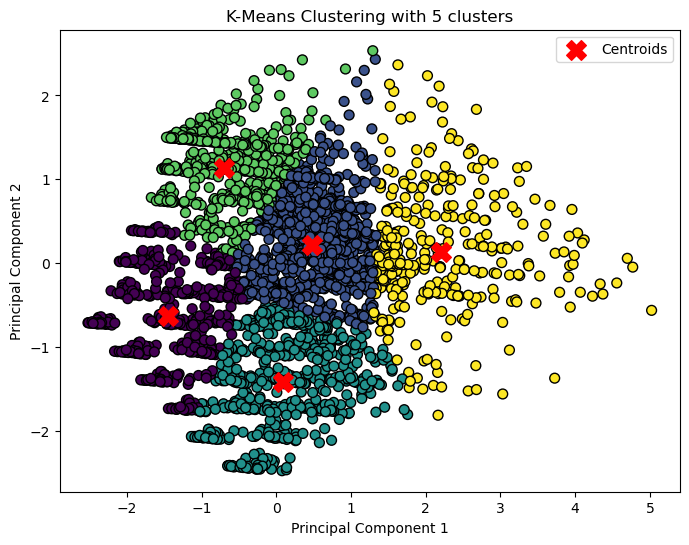

In [70]:
# performing kmeans clustering with 5 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled3)

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 5 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


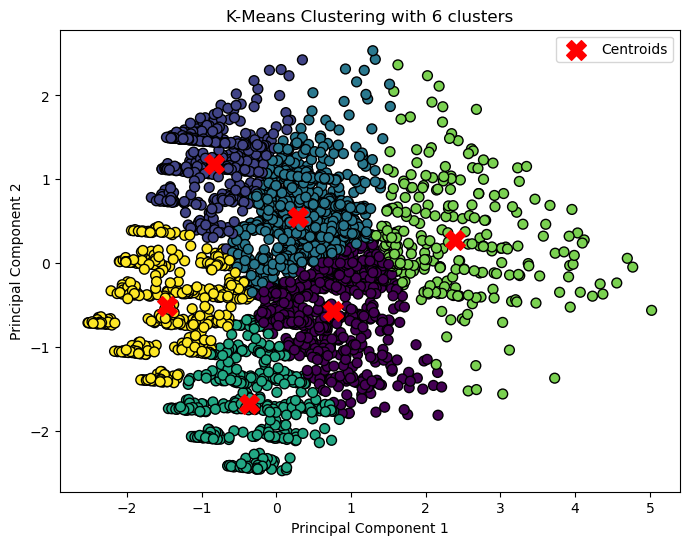

In [71]:
# performing kmeans clustering with 6 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled3)

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 6 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [72]:
X_scaled3_df = pd.DataFrame(X_scaled3, columns = [['NUMBER OF ED VISITS', 'AGE-ADJUSTED ED VISIT RATE', 'NUMERIC YEAR', 'NUMERIC AGE GROUP']])
X_scaled3_df['CLUSTER'] = kmeans.labels_
X_scaled3_df.head()

,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC YEAR,NUMERIC AGE GROUP,CLUSTER
0,6.154118,0.305033,-0.890802,-1.472273,4
1,-0.433399,0.151409,-0.890802,-1.472273,0
2,0.139958,-0.062102,-0.890802,-1.472273,0
3,-0.440836,-0.119386,-0.890802,-1.472273,0
4,-0.500336,-0.291237,-0.890802,-1.472273,0


In [73]:
X_scaled3_df['PCA1'] = X_pca[:, 0]
X_scaled3_df['PCA2'] = X_pca[:, 1]
X_scaled3_df.head()

,NUMBER OF ED VISITS,AGE-ADJUSTED ED VISIT RATE,NUMERIC YEAR,NUMERIC AGE GROUP,CLUSTER,PCA1,PCA2
0,6.154118,0.305033,-0.890802,-1.472273,4,3.229647,1.136367
1,-0.433399,0.151409,-0.890802,-1.472273,0,1.147124,-0.250709
2,0.139958,-0.062102,-0.890802,-1.472273,0,1.177793,-0.116649
3,-0.440836,-0.119386,-0.890802,-1.472273,0,0.965155,-0.236372
4,-0.500336,-0.291237,-0.890802,-1.472273,0,0.833204,-0.238882


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


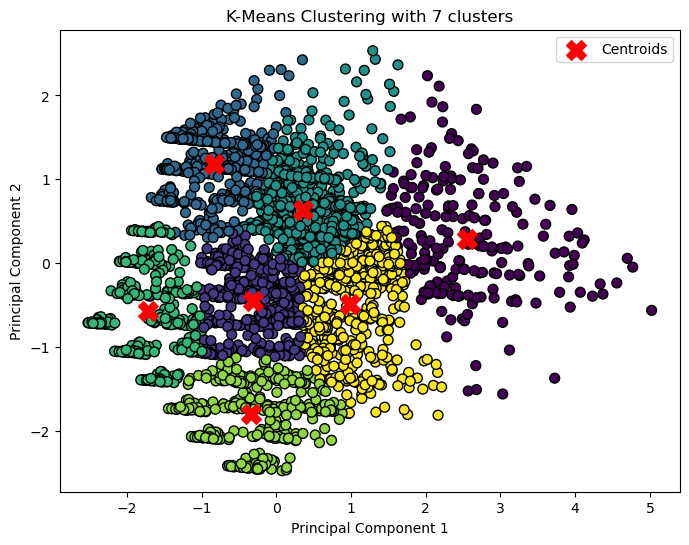

In [74]:
# performing kmeans clustering with 7 clusters

# We would need to transform this to 2 components from current 4 components
pca = PCA(n_components=2)  # Reducing to 2 dimension
X_pca = pca.fit_transform(X_scaled3)

kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['Principal Component 1','Principal Component 2']])

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 7 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#### K Means without categorical

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

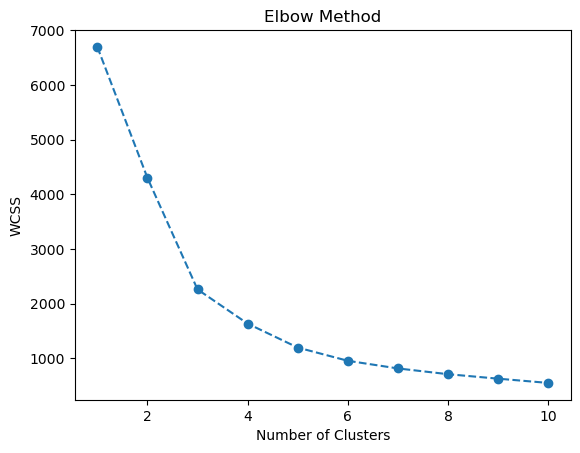

In [77]:
from sklearn.cluster import KMeans
wcss = []

# experimenting for 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled4)
    wcss.append(kmeans.inertia_)

# plotting the curve that is basically elbow method
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Clusters seems to be around 5 or 6 as per elbow method

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super

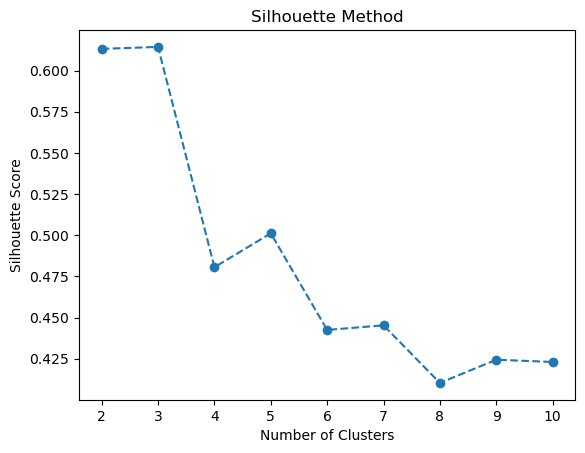

In [78]:
from sklearn.metrics import silhouette_score
s_scores = []

# Plotting with different values of cluster
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled4)
    labels = kmeans.labels_
    s_avg = silhouette_score(X_scaled4, labels)
    s_scores.append(s_avg)

# plotting the silhouette graph
plt.plot(range(2, 11), s_scores, marker='o', linestyle='--')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Silhouette doesn't seem to answer properly, so trying with 5,6,7 clusters

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


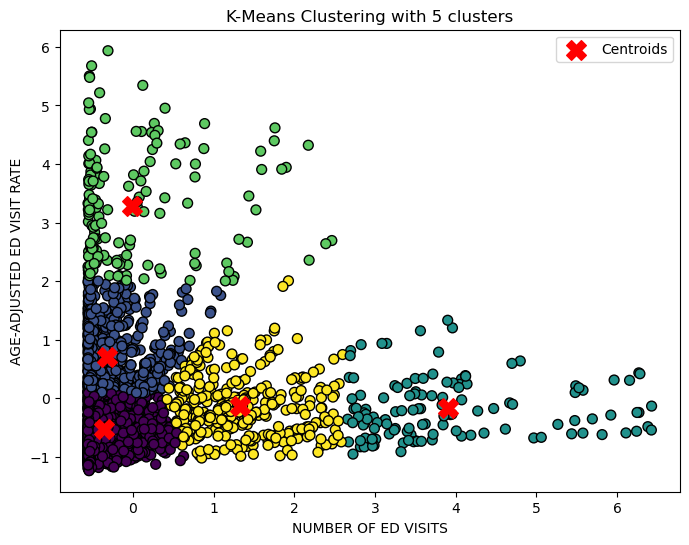

In [79]:
# performing kmeans clustering with 5 clusters

# We don't need PCA here as only 2 features

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_scaled4)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF ED VISITS','AGE-ADJUSTED ED VISIT RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled4[:, 0], X_scaled4[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 5 clusters')
plt.xlabel('NUMBER OF ED VISITS')
plt.ylabel('AGE-ADJUSTED ED VISIT RATE')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


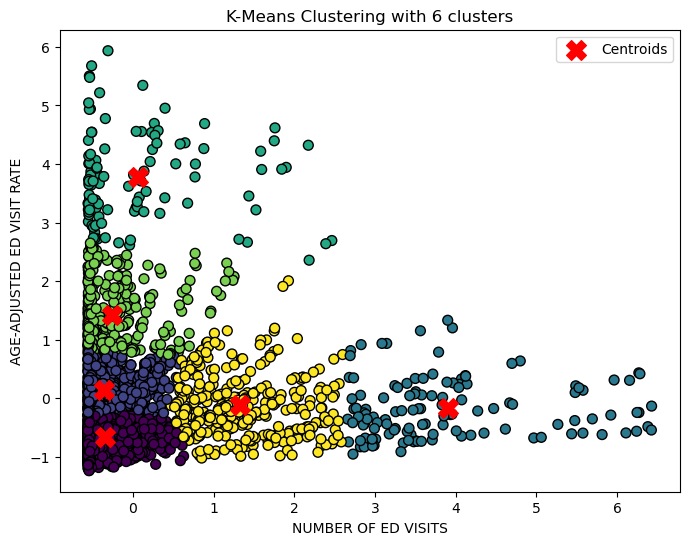

In [80]:
# performing kmeans clustering with 6 clusters

# We don't need PCA here as only 2 features

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_scaled4)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF ED VISITS','AGE-ADJUSTED ED VISIT RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled4[:, 0], X_scaled4[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 6 clusters')
plt.xlabel('NUMBER OF ED VISITS')
plt.ylabel('AGE-ADJUSTED ED VISIT RATE')
plt.legend()
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


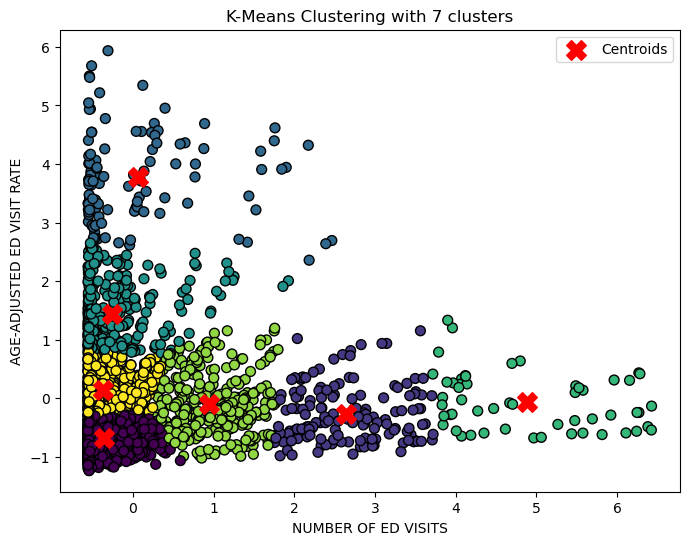

In [81]:
# performing kmeans clustering with 7 clusters

# We don't need PCA here as only 2 features

kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans.fit(X_scaled4)

cluster_labels = kmeans.labels_

centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [['NUMBER OF ED VISITS','AGE-ADJUSTED ED VISIT RATE']])

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled4[:, 0], X_scaled4[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', s=50)

# Plotting the centroids as well
plt.scatter(centroids.values[:, 0], centroids.values[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('K-Means Clustering with 7 clusters')
plt.xlabel('NUMBER OF ED VISITS')
plt.ylabel('AGE-ADJUSTED ED VISIT RATE')
plt.legend()
plt.show()